#Flickr8k Dataset







###Importing Libraries

In [1]:
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Below is the path for the file "Flickr8k.token.txt" on your disk
captions_text = "/content/drive/MyDrive/Datasets/Flickr8k.token (1).txt"
file = open(captions_text, 'r')
doc = file.read()
file.close()

###Mapping image names to captions



In [3]:
def load_descriptions(file):
  descriptions = defaultdict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split(' ')
    
    # take the first token as image id, the rest as description
    image_id  = tokens[0]
    image_desc = tokens[1:]
    
    # extract filename from image id
    image_id = image_id.split('.')[0]
    
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    image_desc = '<startofseq> ' + image_desc + ' <endof>'
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)
  return descriptions

In [4]:
captions = load_descriptions(file)
#stores images names without .jpg extension
image_paths = list(captions.keys())

In [5]:
train_image_paths = image_paths[:8000]
print(len(train_image_paths))

8000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = captions[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

###Preprocess and tokenize captions


In [7]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
    

In [8]:
# Choose the top 5000 words from the vocabulary
batch_size = 32
top_k = 5000
oov_t = "<unk>"
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token=oov_t,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [9]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [10]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [11]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [12]:
vocabulary = set()
for key in captions.keys():
    [vocabulary.update(d.split()) for d in captions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 9131


###Initialize InceptionV3 and load the pretrained Imagenet weights

In [13]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


###Preprocess the images using InceptionV3

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [15]:
file = r"/content/drive/MyDrive/Datasets/Flickr_Data/Flickr_Data/Images1/Images/"

In [16]:
#Converts the name of the image to image path
def img_name_2_path(image_name: str, img_file_path: str = file, ext: str = r".jpg") -> str:
    """
    :param image_name: The name of the image
    :param img_file_path: The path where the image is stored
    :param ext:The extension of the image default is .jpg
    :return: The image path
    """
    image_path = img_file_path + str(image_name) + ext
    return image_path

###Caching the features extracted from InceptionV3

In [17]:
#mapping the image names to path
img_path_list = map(img_name_2_path, img_name_vector)
# Get unique images
encode_train = sorted(set(img_path_list))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [34]:
try:
 for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
except:
  pass

###Split the data into training and testing

In [18]:
img_to_cap_vector = defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


In [19]:
img_name_train = list(map(img_name_2_path, img_name_train))
img_name_val = list(map(img_name_2_path, img_name_val))

In [20]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

###Create a tf.data dataset for training

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [22]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

###Attention Model

###Model!


In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

###Checkpoint

In [29]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [30]:
ckpt_manager

###Training

In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<startofseq>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [33]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [34]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [36]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.2402
Epoch 1 Batch 100 Loss 1.0283
Epoch 1 Batch 200 Loss 1.1096
Epoch 1 Batch 300 Loss 0.9867
Epoch 1 Batch 400 Loss 0.9920
Epoch 1 Loss 1.044810
Time taken for 1 epoch 1118.04 sec

Epoch 2 Batch 0 Loss 1.0387
Epoch 2 Batch 100 Loss 0.9049
Epoch 2 Batch 200 Loss 0.8964
Epoch 2 Batch 300 Loss 0.9287
Epoch 2 Batch 400 Loss 0.9146
Epoch 2 Loss 0.925102
Time taken for 1 epoch 89.05 sec

Epoch 3 Batch 0 Loss 0.9190
Epoch 3 Batch 100 Loss 0.8282
Epoch 3 Batch 200 Loss 0.8513
Epoch 3 Batch 300 Loss 0.8949
Epoch 3 Batch 400 Loss 0.8052
Epoch 3 Loss 0.855296
Time taken for 1 epoch 88.30 sec

Epoch 4 Batch 0 Loss 0.8718
Epoch 4 Batch 100 Loss 0.7354
Epoch 4 Batch 200 Loss 0.8108
Epoch 4 Batch 300 Loss 0.8671
Epoch 4 Batch 400 Loss 0.7911
Epoch 4 Loss 0.800907
Time taken for 1 epoch 89.10 sec

Epoch 5 Batch 0 Loss 0.9322
Epoch 5 Batch 100 Loss 0.7870
Epoch 5 Batch 200 Loss 0.7888
Epoch 5 Batch 300 Loss 0.7134
Epoch 5 Batch 400 Loss 0.7522
Epoch 5 Loss 0.753211
Time taken f

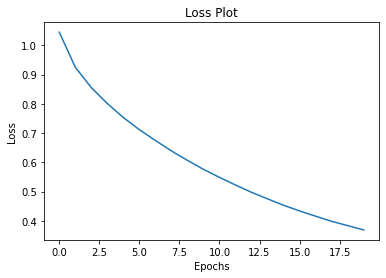

In [37]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


###Caption!

In [35]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<startofseq>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<endof>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [36]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <startofseq> brown puppy walking through the snow <endof>
Prediction Caption: crate jr right chase buggy acting boogie pom pants state school notice cigars bales florescent freak no dome lunges made badge knocks are swings graduation icy minimal rock camouflage ties watermelon strikes viz tournament beagle humans parasailer shake


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


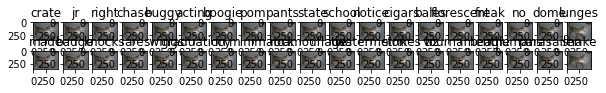

In [40]:
# captions on the validation set
from PIL import Image
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

###Trying in on images

65536/64400 [==============================] - 0s 3us/step
Prediction Caption: tape blouse coat waterfalls herding pig shephard cannonball statues girder eagle course watering partner amnesty packages clothing suits snuggling sunrise photographed backpacks magazines 11 tow carefully waking because coaching fireworks photographed repelling lights photos spreads setter alleyway stretches


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


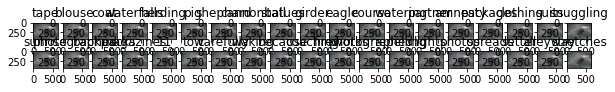

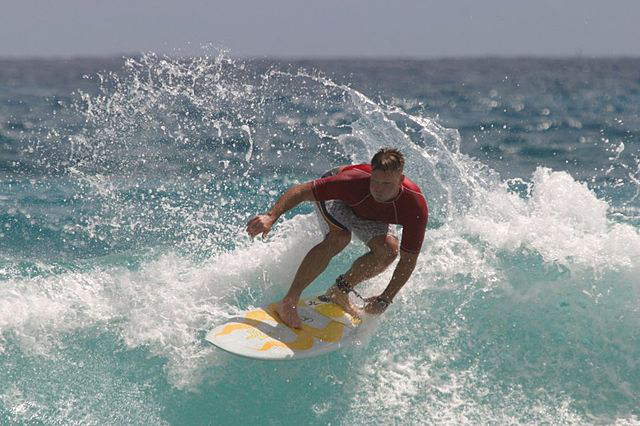

In [39]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)